# Partitionnez vos données - Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

# 1 Preliminary

## 1.2 Imports

Importons les librairies :

In [1]:
import sys
sys.path.append('C:/openclassroom/projet-3/src')
import OpenFoodFacts as ev

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
%matplotlib inline
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy import spatial,stats

## 1.3 Graphics

Chargeons les librairies graphiques :

In [2]:
sns.set()

## 1.4 Data

Nous allons maintenant charger les données. 

-------------------------------------

<br>


Importons notre fichier `informations_nutritionnelles.csv`:

In [3]:
data = pd.read_csv('../data/en.openfoodfacts.org.products.csv', sep='\t', low_memory=False)
print('There are {:,} rows '.format(data.shape[0]) + 'and {} columns in our data'.format(data.shape[1]))


There are 2,958,519 rows and 203 columns in our data


In [4]:
data.set_index('code', inplace=True)

In [5]:
print("Ces données sont vraiment désordonnées ! \nLa colonne 'countries_en' contient {} pays \"uniques\".".format(data['countries_en'].dropna().unique().shape[0]))


Ces données sont vraiment désordonnées ! 
La colonne 'countries_en' contient 6595 pays "uniques".


In [6]:
# We drop all columns that we deem not interesting and we don't intend to use for our investigation.
data = data.drop(columns=['creator',
                          'brands',
                          'brands_tags',
                          'categories',
                          'main_category',
                          'countries',
                          'countries_tags',
                          'additives',
                          'additives_tags',
                          'categories_tags',
                          'states',
                          'states_en',
                          'states_tags',
                          'url',
                          'quantity',
                          'packaging_tags',
                          'packaging',
                          'created_t',
                          'last_modified_t',
                          'pnns_groups_1',
                          'pnns_groups_2',
                          'image_url',
                          'image_small_url',
                         ])

In [7]:
print('Il y a {:,} lignes '.format(data.shape[0]) + 'et {} colonnes dans nos données'.format(data.shape[1]))


Il y a 2,958,519 lignes et 179 colonnes dans nos données



### Gestion des Valeurs Manquantes et des Doublons
<a id="dwn" > 

In [8]:
data.isnull().sum().sort_values()

created_datetime                 0
last_modified_datetime           0
completeness                     3
countries_en                  7843
ecoscore_grade               14069
                            ...   
elaidic-acid_100g          2958514
water-hardness_100g        2958516
allergens_en               2958518
nutrition-score-uk_100g    2958518
cities                     2958518
Length: 179, dtype: int64

In [9]:
#Nous renommons toutes les colonnes qui contiennent un "-" car dans certains scénarios, cela peut poser problème avec Python 3.
data = data.rename(columns={'nutrition-score-fr_100g': 'nutrition_score_fr_100g',
                            'nutrition-score-uk_100g': 'nutrition_score_uk_100g',
                            'vitamin-c_100g': 'vitamin_c_100g',
                            'vitamin-a_100g': 'vitamin_a_100g',
                            'saturated-fat_100g': 'saturated_fat_100g',
                            'trans-fat_100g': 'trans_fat_100g'})

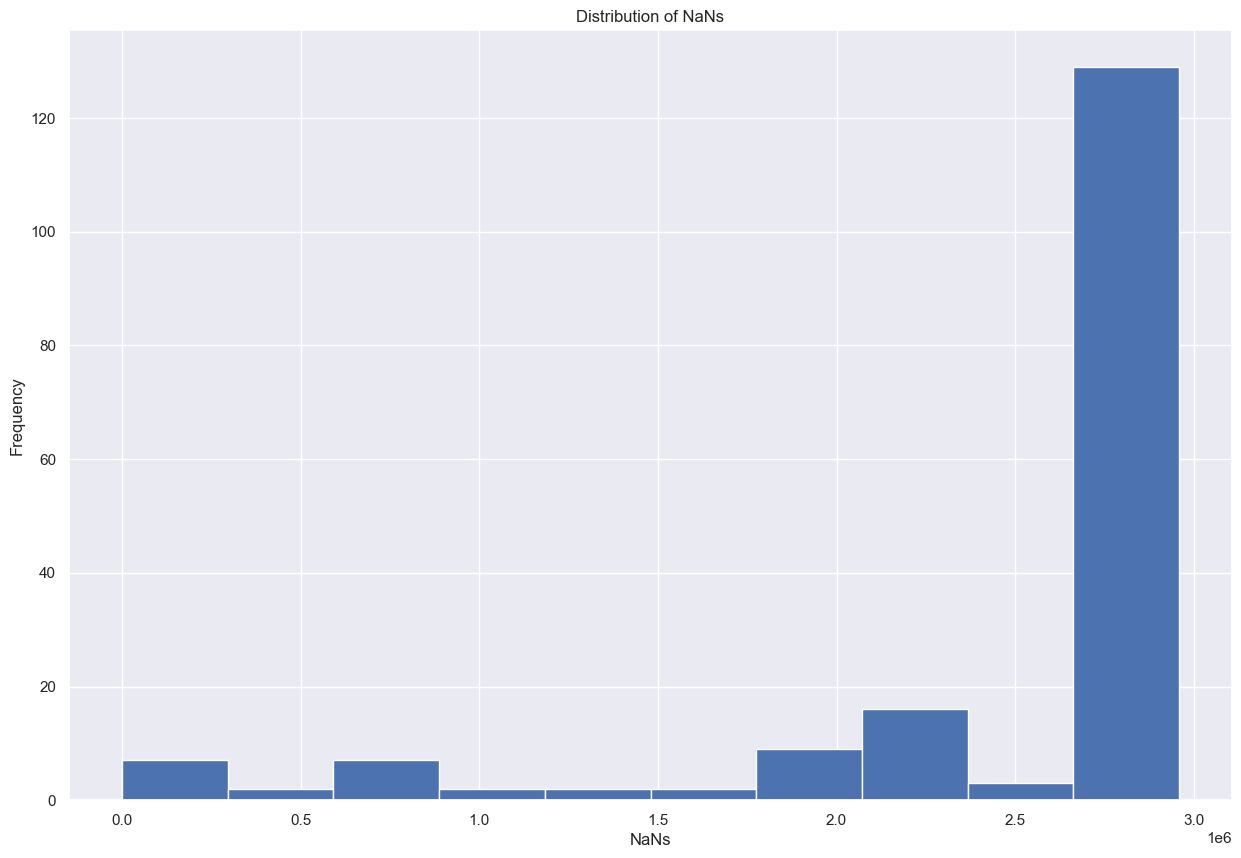

In [10]:
data.isnull().sum().plot(kind='hist', figsize=(15,10))
plt.title('Distribution of NaNs')
plt.xlabel('NaNs')

plt.show()

In [11]:

#Nous supprimons toutes les colonnes qui contiennent moins de 20 % de données utilisables
data = data.dropna(axis=1, how='all')
data = data.dropna(axis=1, thresh=len(data) * 0.2)

In [12]:

#Nous supprimons toutes les lignes qui (après avoir supprimé certaines colonnes) ne contiennent que des NaN.
data = data.dropna(axis=0, how='all') 

In [13]:

print('Il reste maintenant {:,} lignes '.format(data.shape[0]) + 'et {} colonnes dans nos données'.format(data.shape[1]))

Il reste maintenant 2,958,519 lignes et 47 colonnes dans nos données


In [14]:
data.isnull().sum().sort_values()

created_datetime                                               0
last_modified_datetime                                         0
completeness                                                   3
countries_en                                                7843
ecoscore_grade                                             14069
last_modified_by                                          105766
product_name                                              127818
last_image_t                                              435040
last_image_datetime                                       435040
energy_100g                                               659962
proteins_100g                                             673281
carbohydrates_100g                                        675380
fat_100g                                                  675850
sugars_100g                                               698230
energy-kcal_100g                                          706968
saturated_fat_100g       

In [15]:
data['product_name'].fillna(value='Product name unavailable', inplace=True)

In [16]:
cols_100g = [x for x in data.columns if  '_100g' in x]
data = data.reindex(['nutriscore_score']+cols_100g,axis=1)

In [17]:
# Récupération des colonnes avec moins de80% de NaN
cols = []
for i in range(len(data.columns)):
    temp =int(data[data.columns[i]].isnull().sum()/data.shape[0]*100)
    print(data.columns[i],' - ', temp, '% de cellules vides' )
    if temp < 80 : 
        cols.append(data.columns[i])    


nutriscore_score  -  67 % de cellules vides
energy-kcal_100g  -  23 % de cellules vides
energy_100g  -  22 % de cellules vides
fat_100g  -  22 % de cellules vides
saturated_fat_100g  -  24 % de cellules vides
carbohydrates_100g  -  22 % de cellules vides
sugars_100g  -  23 % de cellules vides
fiber_100g  -  65 % de cellules vides
proteins_100g  -  22 % de cellules vides
salt_100g  -  31 % de cellules vides
sodium_100g  -  31 % de cellules vides
fruits-vegetables-nuts-estimate-from-ingredients_100g  -  70 % de cellules vides
nutrition_score_fr_100g  -  67 % de cellules vides


In [18]:
data = data.reindex(columns=cols)
data

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,
00000000000000225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0000000000000207025004,NaN,165.0,690.0,2.0,2.00,65.0,12.6,3.0,1.5,NaN,NaN,NaN,NaN
00000000000003429145,NaN,NaN,NaN,1.4,0.90,9.8,9.8,NaN,2.7,0.10,0.040,0.0,NaN
00000000000026772226,-5,57.0,238.0,0.2,0.10,3.9,3.9,NaN,10.0,0.09,0.036,NaN,-5.0
0000000000017,NaN,375.0,1569.0,7.0,3.08,70.1,15.0,NaN,7.8,1.40,0.560,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
999999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data['nutriscore_score'].isnull().sum()

1982583

In [20]:
data=data[data['nutriscore_score'].notnull()]
data.shape[0]

975936

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 975936 entries, 00000000000026772226 to 99
Data columns (total 13 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   nutriscore_score                                       975936 non-null  object 
 1   energy-kcal_100g                                       936033 non-null  float64
 2   energy_100g                                            971715 non-null  float64
 3   fat_100g                                               971669 non-null  float64
 4   saturated_fat_100g                                     971030 non-null  float64
 5   carbohydrates_100g                                     971305 non-null  float64
 6   sugars_100g                                            971346 non-null  float64
 7   fiber_100g                                             535868 non-null  float64
 8   proteins_100g           

In [22]:
#Nous vérifions s'il y a des doublons dans nos données (cela exclut notre colonne d'index)
data.duplicated().sum()

199722

In [23]:
data[data.duplicated(keep=False)]

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,
00000000000026772226,-5,57.0,238.0,0.2,0.1,3.90,3.90,NaN,10.0,0.0900,0.036,NaN,-5.0
000000000080,9,63.0,264.0,0.0,0.0,15.50,15.50,NaN,0.2,0.0000,0.000,NaN,9.0
0000000005166,4,197.0,824.0,13.0,4.0,3.00,0.90,NaN,17.0,1.1000,0.440,NaN,4.0
0000000043595,8,300.0,1255.0,0.0,0.0,83.33,66.67,10.0,0.0,0.0000,0.000,33.333333,8.0
000000022524,6,823.0,3443.0,91.5,12.6,0.00,0.00,NaN,0.0,0.0025,0.001,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99903336,11,42.0,176.0,0.0,0.0,10.00,10.00,NaN,0.5,0.0000,0.000,67.200000,11.0
999901969406,1,1.0,4.0,0.0,0.0,0.30,0.00,NaN,0.2,0.0000,0.000,NaN,1.0
9999317009398,12,337.2,1411.0,28.4,19.1,0.10,0.10,NaN,20.3,0.8000,0.320,NaN,12.0


In [24]:
#Nous supprimons tous les doublons de nos données
data.drop_duplicates(inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_23452\914060224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop_duplicates(inplace=True)


### Data Types
<a id="dt" > 

In [25]:
data.dtypes

nutriscore_score                                          object
energy-kcal_100g                                         float64
energy_100g                                              float64
fat_100g                                                 float64
saturated_fat_100g                                       float64
carbohydrates_100g                                       float64
sugars_100g                                              float64
fiber_100g                                               float64
proteins_100g                                            float64
salt_100g                                                float64
sodium_100g                                              float64
fruits-vegetables-nuts-estimate-from-ingredients_100g    float64
nutrition_score_fr_100g                                  float64
dtype: object

#Élimination des Valeurs Aberrantes
<a id="eo" >

In [26]:
data.describe()

,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g
count,741897.000000,7.753360e+05,775331.000000,774802.000000,774973.000000,775091.000000,4.308430e+05,775321.000000,7.757580e+05,7.757580e+05,491804.000000,776213.000000
mean,277.964110,1.745150e+03,15.311535,5.269911,28.532351,13.067657,2.324172e+03,8.583777,2.598321e+02,1.039328e+02,9.655146,9.378099
std,265.063773,5.173704e+05,1135.793131,113.902709,117.008780,115.095250,1.523493e+06,11.071834,1.605656e+05,6.422624e+04,30.955636,8.653470
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-1.000000,-4.000000e+00,-15.000000,0.000000e+00,0.000000e+00,0.000000,-15.000000
25%,115.000000,4.770000e+02,1.300000,0.200000,4.700000,1.000000,0.000000e+00,2.100000,1.000000e-01,4.000000e-02,0.000000,2.000000
50%,261.000000,1.084000e+03,8.108108,2.000000,17.500000,4.000000,1.700000e+00,6.200000,6.032804e-01,2.412000e-01,0.000000,10.000000
75%,402.000000,1.674000e+03,21.900000,7.140000,52.000000,19.000000,3.800000e+00,12.000000,1.322500e+00,5.290000e-01,5.000000,16.000000
max,105647.000000,4.555600e+08,999999.000000,99999.000000,99999.000000,99999.000000,1.000000e+09,3000.000000,1.000000e+08,4.000000e+07,13461.000000,40.000000


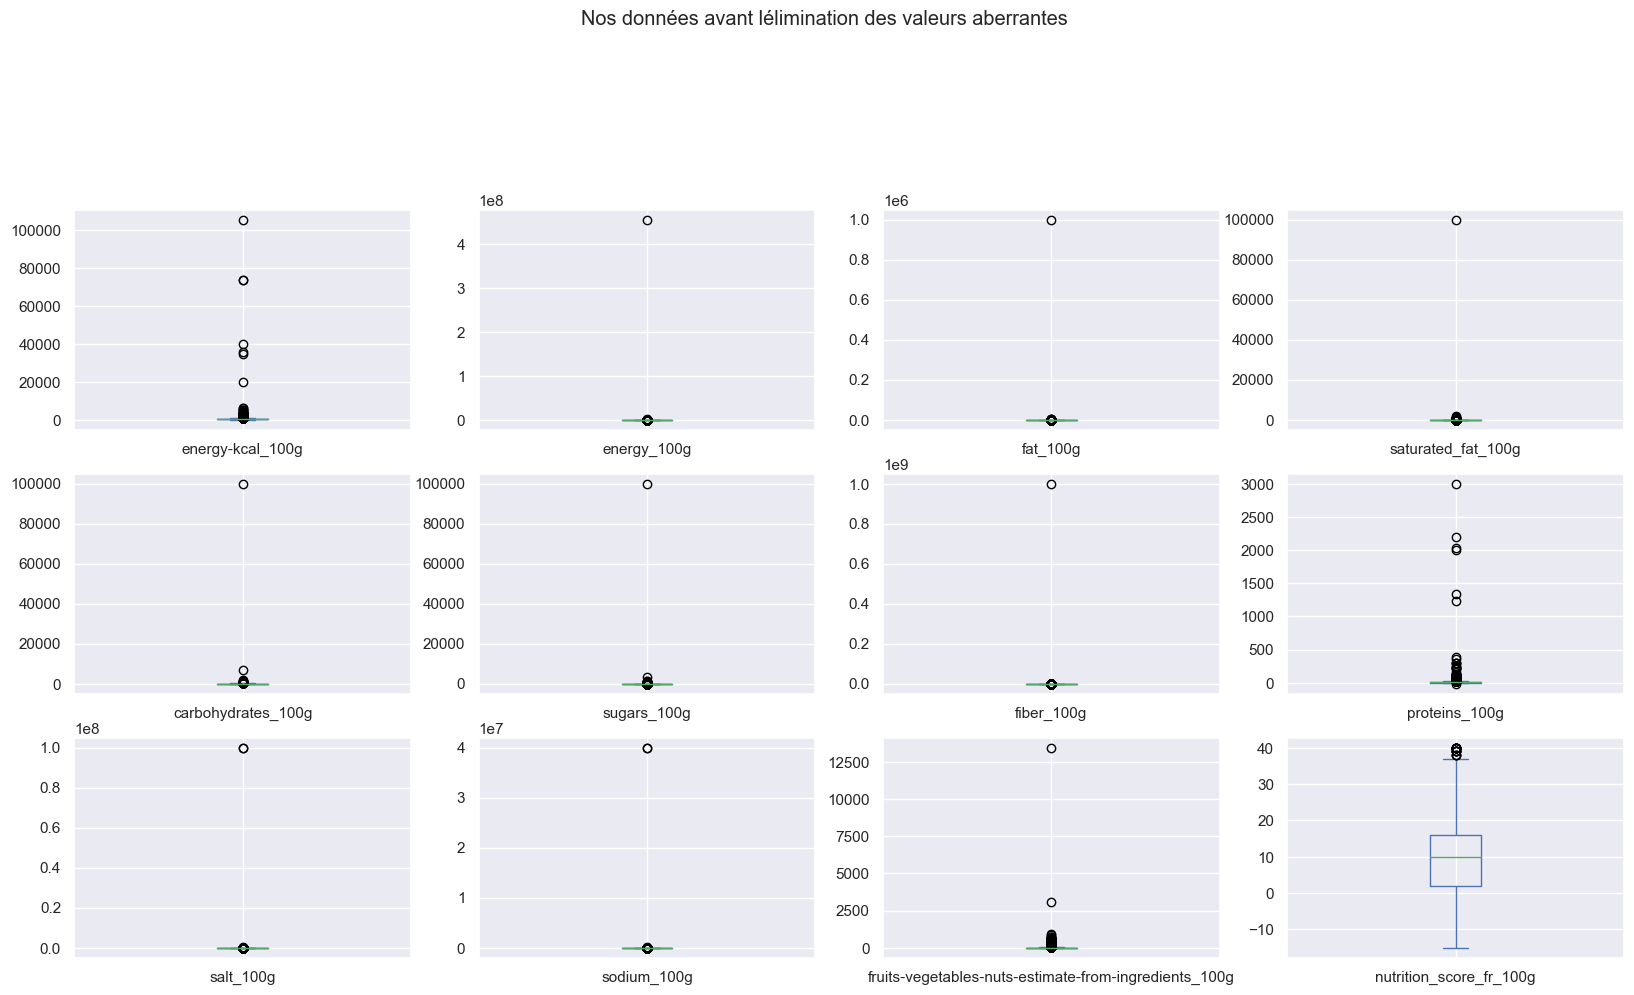

In [27]:
data.select_dtypes(include=float).plot(kind='box', subplots=True, title='Nos données avant lélimination des valeurs aberrantes', figsize=(20,20), layout=(6,4))

plt.show()


#Nous allons maintenant éliminer toutes les lignes qui contiennent des valeurs impossibles par définition.

In [28]:
# Create a DataFrame to check data types of each column
data_types_df = data.apply(lambda col: col.apply(type))

# Identify columns with mixed data types
mixed_data_type_columns = data_types_df.columns[data_types_df.apply(lambda col: len(col.unique()) > 1)]

# Print the columns with mixed data types
print("Columns with Mixed Data Types:")
print(mixed_data_type_columns)


Columns with Mixed Data Types:
Index([], dtype='object')


In [29]:
data = data[(data['fat_100g'] + data['carbohydrates_100g'] + data['proteins_100g'])<=100]

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 771802 entries, 00000000000026772226 to 99
Data columns (total 13 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   nutriscore_score                                       771802 non-null  object 
 1   energy-kcal_100g                                       738428 non-null  float64
 2   energy_100g                                            771763 non-null  float64
 3   fat_100g                                               771802 non-null  float64
 4   saturated_fat_100g                                     771267 non-null  float64
 5   carbohydrates_100g                                     771802 non-null  float64
 6   sugars_100g                                            771550 non-null  float64
 7   fiber_100g                                             428524 non-null  float64
 8   proteins_100g           

In [31]:
cols_100g = [x for x in data.columns if  '_100g' in x]
data = data.reindex(['nutriscore_score']+cols_100g,axis=1)

Text(0.5, 1.0, 'Boite à moustache energy_100g avant cleaning')

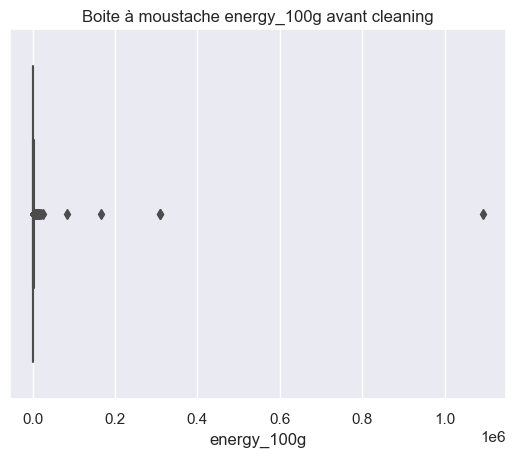

In [32]:
ax = sns.boxplot(x=data["energy_100g"])
plt.title('Boite à moustache energy_100g avant cleaning')# boxplot name to change

In [33]:
data['energy_100g']= data['energy_100g'].where(data['energy_100g']<data['energy_100g'].quantile(0.995))

Text(0.5, 1.0, 'Boite à moustache energy_100g aprés cleaning')

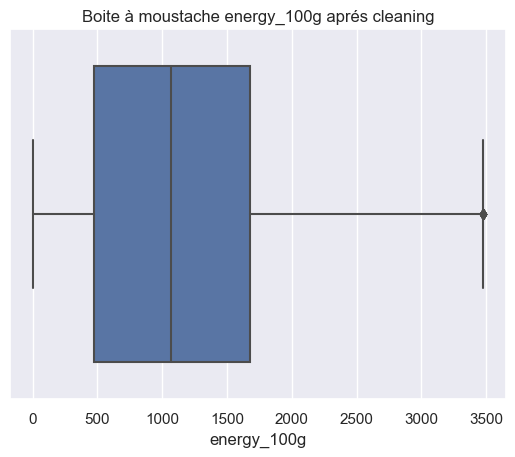

In [34]:
ax = sns.boxplot(x=data["energy_100g"])
plt.title('Boite à moustache energy_100g aprés cleaning')# boxplot name to change

In [35]:

data['fat_100g']= data['fat_100g'].where(data['fat_100g']<data['fat_100g'].quantile(0.995))
data['saturated_fat_100g']= data['saturated_fat_100g'].where(data['saturated_fat_100g']<data['saturated_fat_100g'].quantile(0.995))
data['carbohydrates_100g']= data['carbohydrates_100g'].where(data['carbohydrates_100g']<data['carbohydrates_100g'].quantile(0.995))
data['sugars_100g']= data['sugars_100g'].where(data['sugars_100g']<data['sugars_100g'].quantile(0.995))
data['fiber_100g']= data['fiber_100g'].where(data['fiber_100g']<data['fiber_100g'].quantile(0.995))
data['proteins_100g']= data['proteins_100g'].where(data['proteins_100g']<data['proteins_100g'].quantile(0.995))
data['salt_100g']= data['salt_100g'].where(data['salt_100g']<data['salt_100g'].quantile(0.995))
data['sodium_100g']= data['sodium_100g'].where(data['sodium_100g']<data['sodium_100g'].quantile(0.995))




In [36]:
print("There are {:,} rows left in our data ".format(data.shape[0]))

There are 771,802 rows left in our data 


In [37]:
data.describe()

,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g
count,738428.000000,767898.000000,767400.000000,767399.000000,767903.000000,767563.000000,426375.000000,767918.000000,767794.000000,767793.000000,488850.000000,771802.000000
mean,276.717457,1136.073609,13.434019,4.814108,27.896472,12.468831,2.891313,8.205805,1.002785,0.401111,9.659397,9.359964
std,234.266761,742.322985,15.379773,6.443671,26.174277,17.147284,3.833248,8.060533,1.550281,0.620112,30.990435,8.644348
min,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-4.000000,-15.000000,0.000000,0.000000,0.000000,-15.000000
25%,115.000000,473.000000,1.300000,0.200000,4.700000,0.904950,0.000000,2.070000,0.100000,0.040000,0.000000,2.000000
50%,260.000000,1071.000000,8.000000,2.000000,17.000000,4.000000,1.700000,6.100000,0.600000,0.240000,0.000000,10.000000
75%,400.000000,1674.000000,21.400000,7.000000,51.700000,18.000000,3.800000,11.700000,1.300000,0.520000,5.139286,16.000000
max,73820.100000,3478.000000,91.910000,42.857143,94.900000,80.952400,30.769231,61.904800,17.980000,7.192000,13461.000000,40.000000


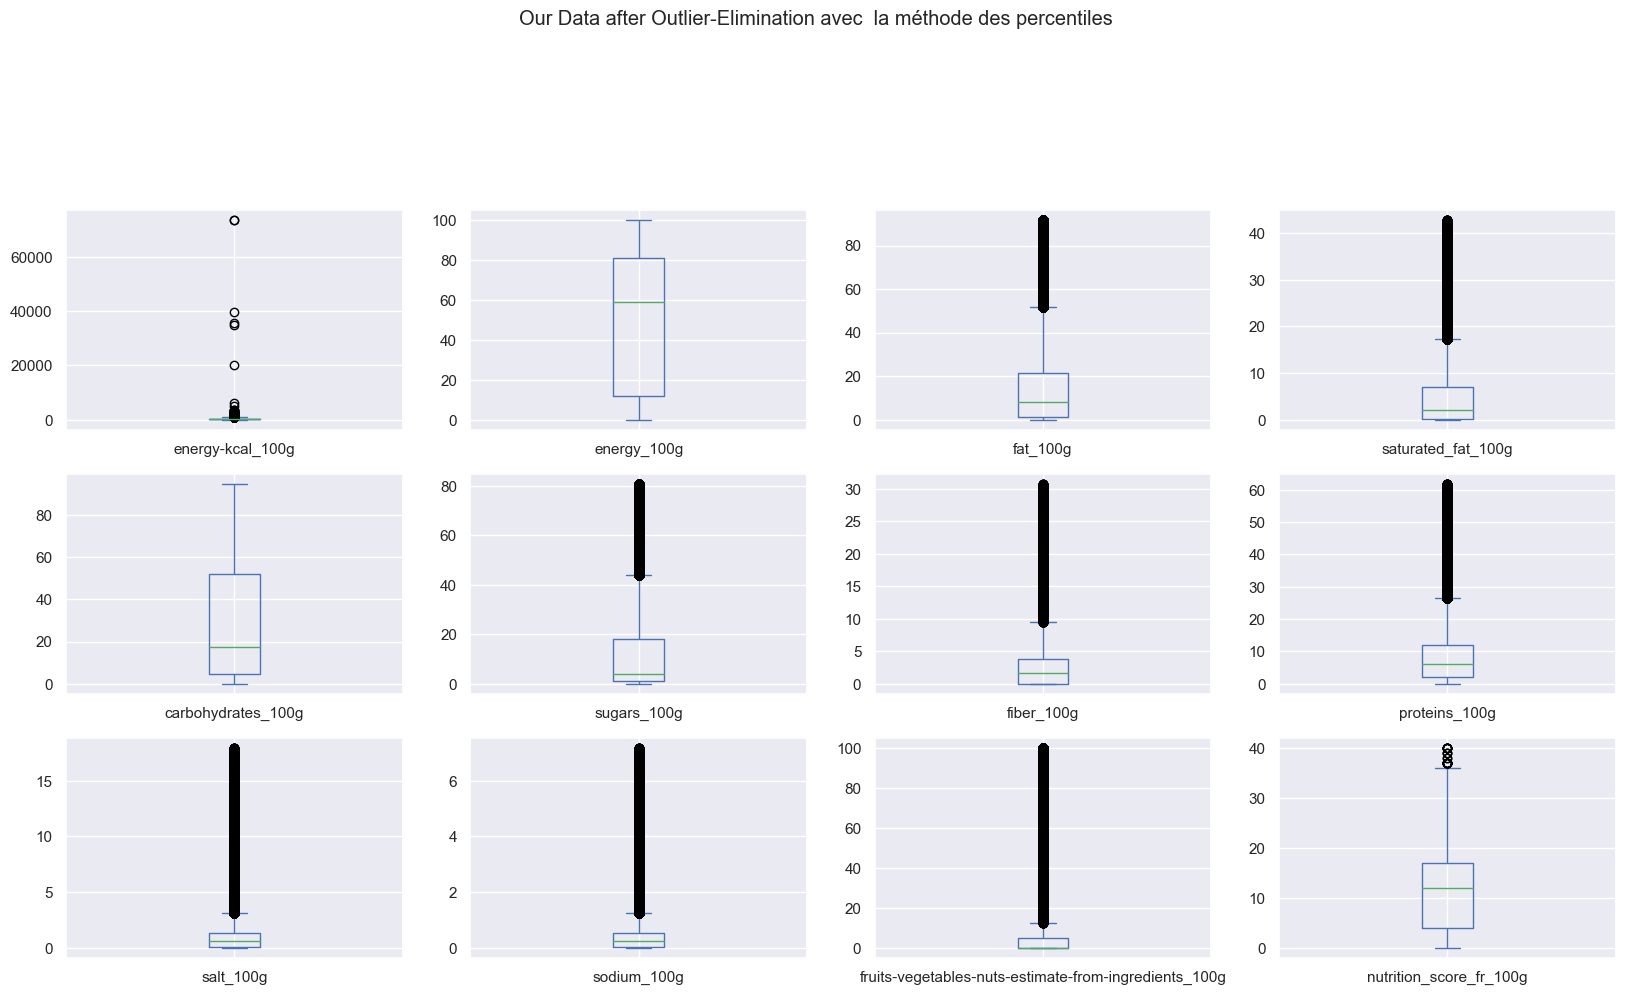

In [80]:
data.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data after Outlier-Elimination avec  la méthode des percentiles', figsize=(20,20), layout=(6,4))

plt.show()

In [39]:
data['nan']= len(data.columns)-data.count(axis=1)

In [40]:
data['nan'].describe()

count    771802.000000
mean          0.899843
std           0.873535
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max           7.000000
Name: nan, dtype: float64

In [41]:
data=data[data['nan']<3]

In [42]:
data=data.drop(columns=['nan'])
data

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g
code,,,,,,,,,,,,,
00000000000026772226,-5,57.0,238.0,0.2,0.1,3.9,3.9,NaN,10.0,0.09,0.036,NaN,-5.0
0000000000100,18,NaN,936.0,8.2,2.2,29.0,22.0,0.0,5.1,4.60,1.840,0.0,18.0
000000000080,9,63.0,264.0,0.0,0.0,15.5,15.5,NaN,0.2,0.00,0.000,NaN,9.0
0000000000949,1,32.0,134.0,0.3,0.1,5.3,3.9,NaN,0.9,0.42,0.168,NaN,1.0
0000000001281,14,381.0,1594.0,22.0,15.5,27.3,21.9,4.4,4.6,0.10,0.040,NaN,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999999004360,15,333.0,1393.0,20.2,6.0,30.9,10.4,NaN,7.4,1.10,0.440,0.0,15.0
9999999175305,12,NaN,925.0,7.6,4.8,35.0,24.0,NaN,2.6,0.28,0.112,12.0,12.0
99999995,-2,131.0,548.0,5.0,2.3,0.0,0.0,NaN,21.5,0.18,0.072,0.0,-2.0


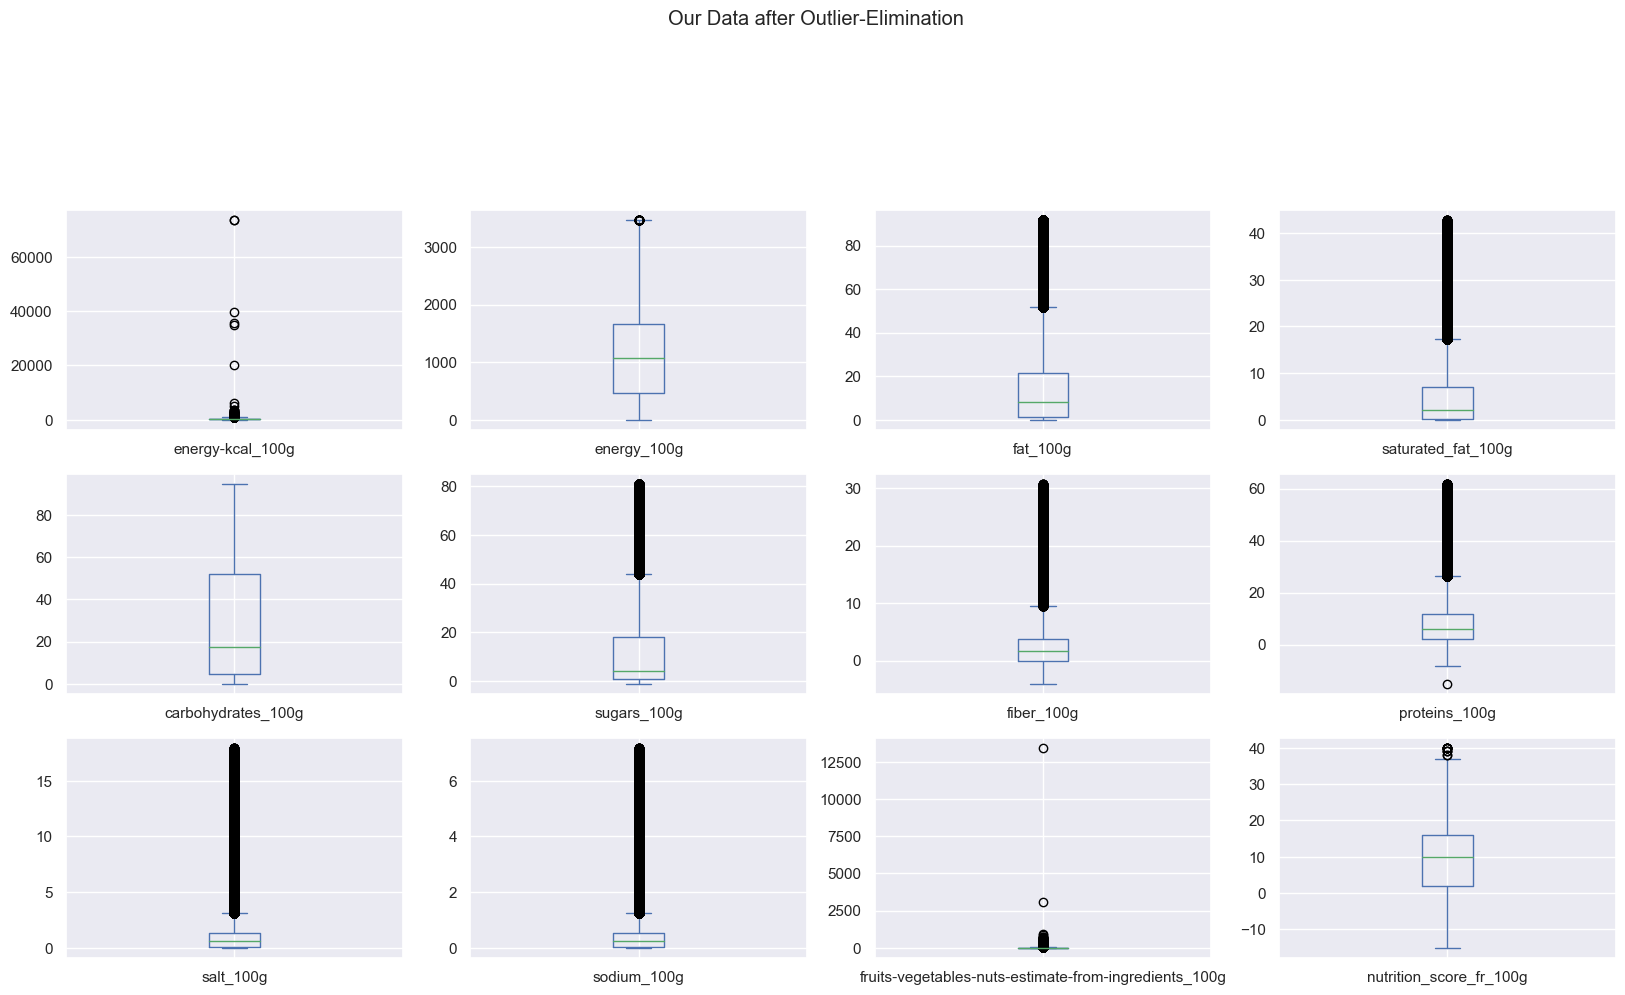

In [43]:
data.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data after Outlier-Elimination', figsize=(20,20), layout=(6,4))

plt.show()

Il parait que l 'elimination des outliniers univariable est impossible que pour l 'energie il faut utiliser la standarisation et les imputers des valeurs manquantes.

C:\Users\User\AppData\Local\Temp\ipykernel_23452\2290790081.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['sugars_100g'])


Text(0.5, 1.0, 'Distribution de sugars_100g aprés cleaning')

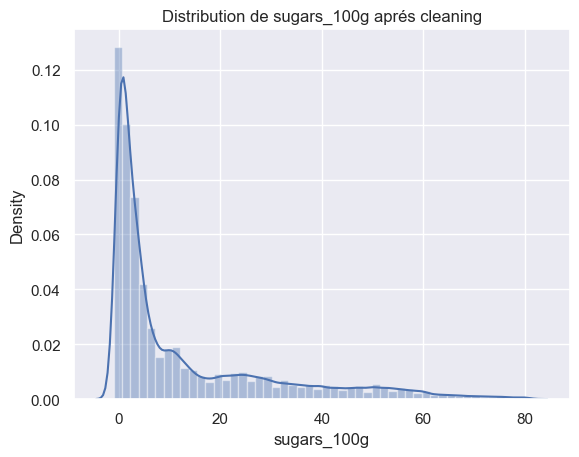

In [44]:
sns.distplot(data['sugars_100g'])
plt.title('Distribution de sugars_100g aprés cleaning')

In [45]:
# For loop to set as NaN the values >100g or <0g

changes = 0
for i in range(data.shape[0]):
    for j in range(2,len(data.columns)):
        if not np.isnan(data.iat[i,j]):
            if ((data.iat[i,j]<0)|(data.iat[i,j]>100)):
                data.iat[i,j] = np.nan
                changes +=1
changes    

835499

In [46]:
data['sugars_100g'].describe()

count    756893.000000
mean         12.539806
std          17.142690
min           0.000000
25%           1.000000
50%           4.000000
75%          18.200000
max          80.952400
Name: sugars_100g, dtype: float64

In [47]:
data['nan']= len(data.columns)-data.count(axis=1)

In [48]:
data['nan'].describe()

count    758985.000000
mean          1.960319
std           0.875747
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: nan, dtype: float64

In [49]:
data.to_csv('../data/Cleaned_Data_Oen_Foods_Facts.csv', index=True)

In [51]:
scaler = StandardScaler().fit(data)
scaled_data= scaler.transform(data)

In [52]:
with open('../data/scaler_1.pickle', 'wb') as file:
    pickle.dump(scaler, file)

In [53]:
imputer = KNNImputer(n_neighbors=5)

knn_data = imputer.fit_transform(scaled_data)

In [54]:
filled_data = scaler.inverse_transform(knn_data)

In [55]:
data_filled = pd.DataFrame(filled_data, columns=data.columns, index=data.index)

In [56]:
data_filled['nan']= len(data_filled.columns)-data_filled.count(axis=1)

data_filled.describe()

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g,nan
count,758985.000000,758985.000000,758985.000000,758985.000000,758985.000000,7.589850e+05,758985.000000,758985.000000,758985.000000,758985.000000,7.589850e+05,758985.000000,758985.000000,758985.0
mean,9.301326,272.101495,37.010330,13.548257,4.841245,2.817464e+01,12.665558,2.357473,8.285755,1.016030,4.057938e-01,10.692772,9.763327,0.0
std,8.653644,228.770487,23.585651,15.519944,6.469095,2.621223e+01,17.314630,3.353674,8.066883,1.568634,6.244909e-01,23.126985,8.010175,0.0
min,-15.000000,0.000000,0.000000,0.000000,0.000000,3.552714e-15,0.000000,0.000000,0.000000,0.000000,-5.551115e-17,0.000000,0.000000,0.0
25%,2.000000,113.000000,19.805200,1.300000,0.200000,4.800000e+00,1.000000,0.200000,2.200000,0.100000,4.000000e-02,0.000000,2.000000,0.0
50%,10.000000,256.000000,33.000000,8.100000,2.000000,1.763000e+01,4.000000,1.211400,6.200000,0.615000,2.460000e-01,0.000000,10.000000,0.0
75%,16.000000,400.000000,50.200000,21.430000,7.000000,5.200000e+01,18.700000,3.057143,11.900000,1.312500,5.250000e-01,9.000000,16.000000,0.0
max,40.000000,73820.100000,100.000000,91.910000,42.857143,9.490000e+01,80.952400,30.769231,61.904800,17.980000,7.192000e+00,100.000000,40.000000,0.0


In [57]:
data_filled

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g,nan
code,,,,,,,,,,,,,,
00000000000026772226,-5.0,57.0,40.40,0.2,0.1,3.900000e+00,3.9,0.220000,10.0,0.09,3.600000e-02,0.000000,0.0,0
0000000000100,18.0,205.0,5.40,8.2,2.2,2.900000e+01,22.0,0.000000,5.1,4.60,1.840000e+00,0.000000,18.0,0
000000000080,9.0,63.0,25.20,0.0,0.0,1.550000e+01,15.5,1.394000,0.2,0.00,-5.551115e-17,100.000000,9.0,0
0000000000949,1.0,32.0,99.20,0.3,0.1,5.300000e+00,3.9,0.842000,0.9,0.42,1.680000e-01,18.333333,1.0,0
0000000001281,14.0,381.0,28.00,22.0,15.5,2.730000e+01,21.9,4.400000,4.6,0.10,4.000000e-02,17.100000,14.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9999999004360,15.0,333.0,9.40,20.2,6.0,3.090000e+01,10.4,2.125497,7.4,1.10,4.400000e-01,0.000000,15.0,0
9999999175305,12.0,229.6,50.00,7.6,4.8,3.500000e+01,24.0,1.300000,2.6,0.28,1.120000e-01,12.000000,12.0,0
99999995,-2.0,131.0,56.88,5.0,2.3,3.552714e-15,0.0,0.000000,21.5,0.18,7.200000e-02,0.000000,0.0,0


In [58]:
data_filled.to_csv ('../data/data_Filled_Open_Foods.csv', index = False, header=True)

## Drop Sum > 100g (Supprimer les lignes avec une somme supérieure à 100 g « macro-nourriture » )

In [59]:
filled= pd.read_csv("../data/data_Filled_Open_Foods.csv")

In [60]:
filled

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g,nan
0,-5.0,57.0,40.40,0.2,0.1,3.900000e+00,3.9,0.220000,10.0,0.09,3.600000e-02,0.000000,0.0,0
1,18.0,205.0,5.40,8.2,2.2,2.900000e+01,22.0,0.000000,5.1,4.60,1.840000e+00,0.000000,18.0,0
2,9.0,63.0,25.20,0.0,0.0,1.550000e+01,15.5,1.394000,0.2,0.00,-5.551115e-17,100.000000,9.0,0
3,1.0,32.0,99.20,0.3,0.1,5.300000e+00,3.9,0.842000,0.9,0.42,1.680000e-01,18.333333,1.0,0
4,14.0,381.0,28.00,22.0,15.5,2.730000e+01,21.9,4.400000,4.6,0.10,4.000000e-02,17.100000,14.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758980,15.0,333.0,9.40,20.2,6.0,3.090000e+01,10.4,2.125497,7.4,1.10,4.400000e-01,0.000000,15.0,0
758981,12.0,229.6,50.00,7.6,4.8,3.500000e+01,24.0,1.300000,2.6,0.28,1.120000e-01,12.000000,12.0,0
758982,-2.0,131.0,56.88,5.0,2.3,3.552714e-15,0.0,0.000000,21.5,0.18,7.200000e-02,0.000000,0.0,0
758983,25.0,24.0,100.00,28.0,13.0,7.000000e+01,49.0,6.000000,2.0,3.00,1.200000e+00,5.200000,25.0,0


In [61]:
filled=filled.drop(columns='nan')
filled.head(50)

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g
0,-5.0,57.00000,40.4000,0.200000,0.100,3.900000e+00,3.900000,0.220000,10.00,0.0900,3.600000e-02,0.000000,0.0
1,18.0,205.00000,5.4000,8.200000,2.200,2.900000e+01,22.000000,0.000000,5.10,4.6000,1.840000e+00,0.000000,18.0
2,9.0,63.00000,25.2000,0.000000,0.000,1.550000e+01,15.500000,1.394000,0.20,0.0000,-5.551115e-17,100.000000,9.0
3,1.0,32.00000,99.2000,0.300000,0.100,5.300000e+00,3.900000,0.842000,0.90,0.4200,1.680000e-01,18.333333,1.0
4,14.0,381.00000,28.0000,22.000000,15.500,2.730000e+01,21.900000,4.400000,4.60,0.1000,4.000000e-02,17.100000,14.0
5,-2.0,157.00000,21.8000,0.000000,0.000,3.600000e+01,27.000000,3.600000,0.60,0.0000,-5.551115e-17,84.980000,1.0
6,1.0,143.00000,49.5000,12.700000,1.000,3.900000e+00,1.000000,2.006667,1.90,0.2700,1.080000e-01,53.487143,1.0
7,14.0,397.00000,32.1576,33.000000,21.600,1.000000e-01,0.100000,0.420000,25.00,1.3000,5.200000e-01,0.000000,14.0
8,4.0,197.00000,57.2000,13.000000,4.000,3.000000e+00,0.900000,2.100000,17.00,1.1000,4.400000e-01,6.286000,4.0
9,0.0,197.00000,61.9000,5.000000,1.100,2.870000e+01,3.000000,2.283030,8.40,0.4670,1.868000e-01,10.722874,0.0


In [62]:
filled['sum_100g']=filled['fat_100g']+filled['carbohydrates_100g']+filled['fiber_100g']+filled['proteins_100g']+filled['salt_100g']
filled.head()

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g,sum_100g
0,-5.0,57.0,40.4,0.2,0.1,3.9,3.9,0.220,10.0,0.09,3.600000e-02,0.000000,0.0,14.410
1,18.0,205.0,5.4,8.2,2.2,29.0,22.0,0.000,5.1,4.60,1.840000e+00,0.000000,18.0,46.900
2,9.0,63.0,25.2,0.0,0.0,15.5,15.5,1.394,0.2,0.00,-5.551115e-17,100.000000,9.0,17.094
3,1.0,32.0,99.2,0.3,0.1,5.3,3.9,0.842,0.9,0.42,1.680000e-01,18.333333,1.0,7.762
4,14.0,381.0,28.0,22.0,15.5,27.3,21.9,4.400,4.6,0.10,4.000000e-02,17.100000,14.0,58.400


In [63]:
filled['sum_100g'].describe()

count    7.589850e+05
mean     5.338215e+01
std      3.205213e+01
min      3.552714e-15
25%      2.486000e+01
50%      4.890000e+01
75%      8.701500e+01
max      1.317000e+02
Name: sum_100g, dtype: float64

In [64]:
filled= filled.loc[filled['sum_100g']<=100]

In [66]:
filled= filled.drop(columns='sum_100g')

In [67]:
filled

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g
0,-5.0,57.0,40.4000,0.2,0.1,3.900000e+00,3.9,0.220000,10.0,0.09,3.600000e-02,0.000000,0.0
1,18.0,205.0,5.4000,8.2,2.2,2.900000e+01,22.0,0.000000,5.1,4.60,1.840000e+00,0.000000,18.0
2,9.0,63.0,25.2000,0.0,0.0,1.550000e+01,15.5,1.394000,0.2,0.00,-5.551115e-17,100.000000,9.0
3,1.0,32.0,99.2000,0.3,0.1,5.300000e+00,3.9,0.842000,0.9,0.42,1.680000e-01,18.333333,1.0
4,14.0,381.0,28.0000,22.0,15.5,2.730000e+01,21.9,4.400000,4.6,0.10,4.000000e-02,17.100000,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
758979,0.0,351.0,18.1034,0.5,0.0,8.000000e+01,0.0,1.000000,7.0,0.00,-5.551115e-17,0.000000,0.0
758980,15.0,333.0,9.4000,20.2,6.0,3.090000e+01,10.4,2.125497,7.4,1.10,4.400000e-01,0.000000,15.0
758981,12.0,229.6,50.0000,7.6,4.8,3.500000e+01,24.0,1.300000,2.6,0.28,1.120000e-01,12.000000,12.0
758982,-2.0,131.0,56.8800,5.0,2.3,3.552714e-15,0.0,0.000000,21.5,0.18,7.200000e-02,0.000000,0.0


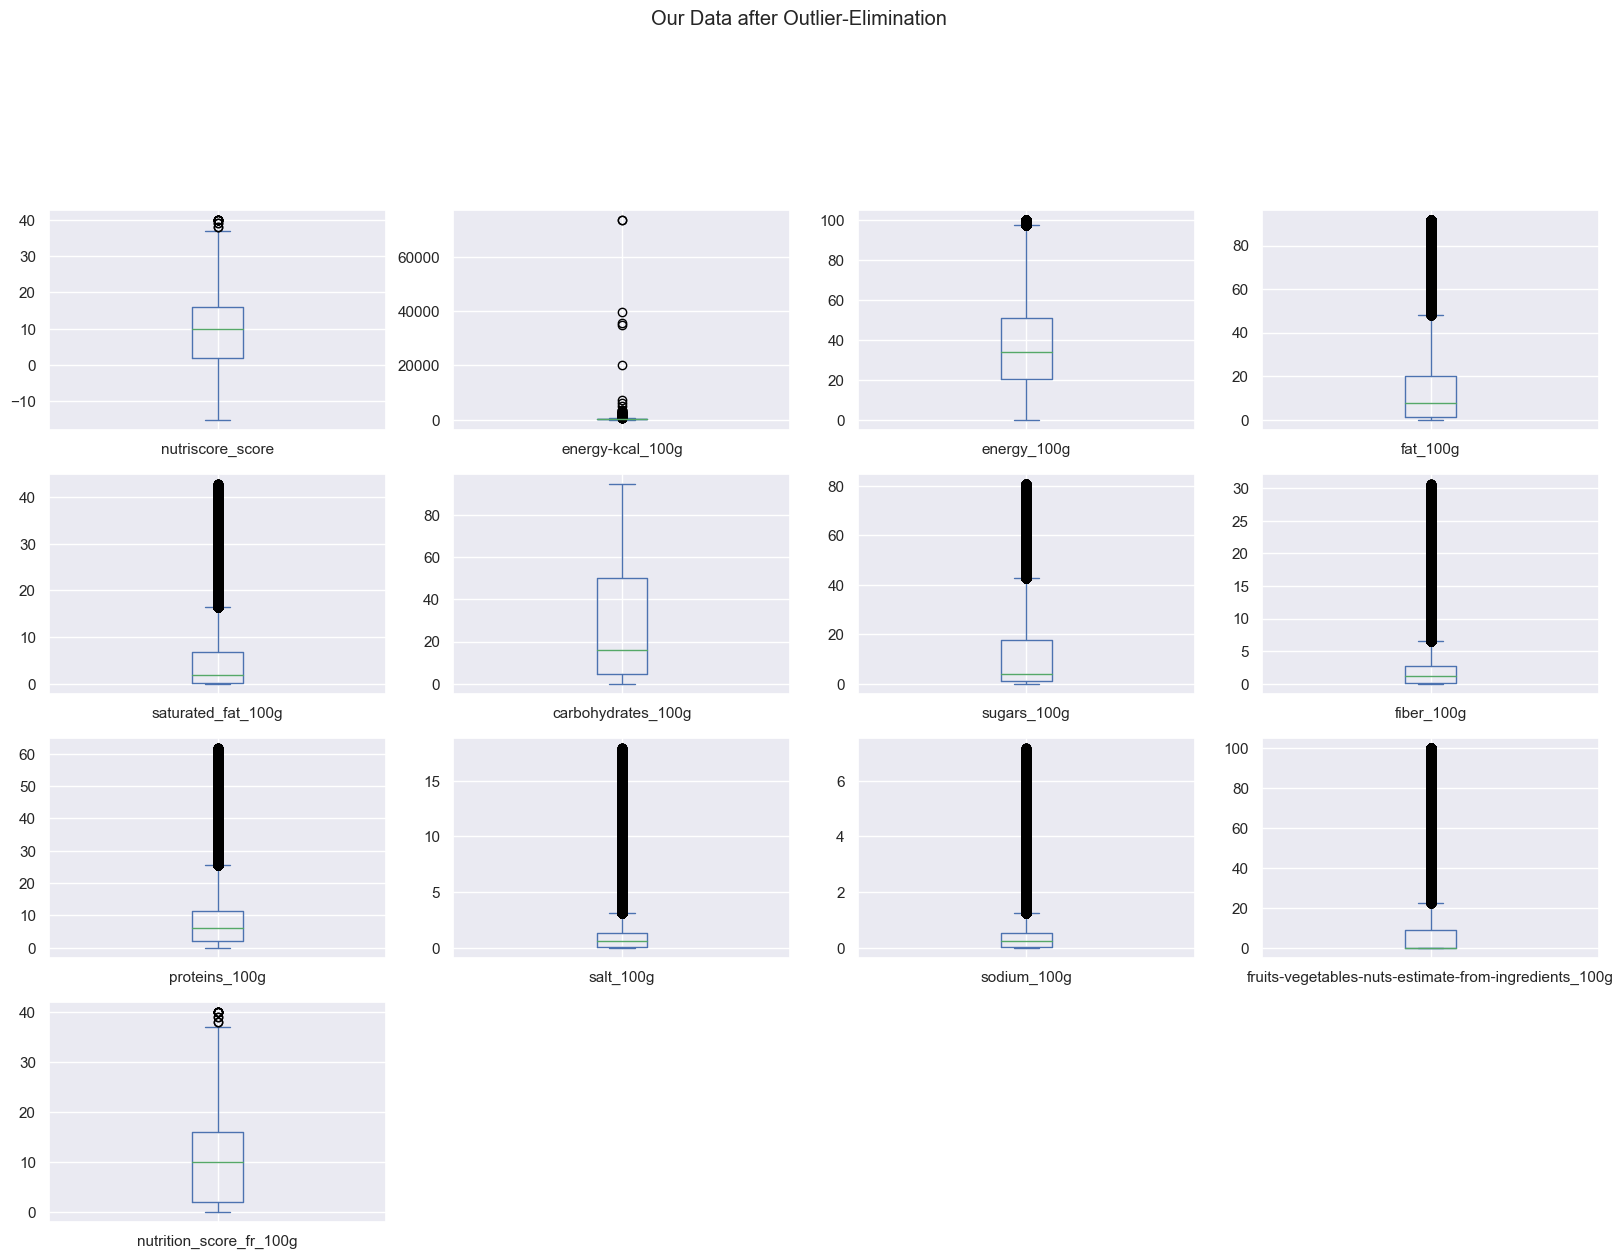

In [68]:
filled.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data after Outlier-Elimination', figsize=(20,20), layout=(6,4))

plt.show()

## KDTree est utiliser pour repérer les valeurs aberrantes multivariées 

In [69]:
test_kdtree=filled.copy()

In [70]:
scaler = StandardScaler().fit(test_kdtree)
scaled_data= scaler.transform(test_kdtree)
scaled_tree = spatial.KDTree(scaled_data)
neighbours_scaled = scaled_tree.query(scaled_data,k=6)
dist_scaled = pd.DataFrame(neighbours_scaled[0])
dist_scaled = dist_scaled.drop(columns=0)
dist_scaled['mean']=dist_scaled.mean(axis=1)
dist_scaled['mean'].describe()

count    725336.000000
mean          0.297736
std           0.382971
min           0.000000
25%           0.130220
50%           0.247663
75%           0.390158
max         144.998894
Name: mean, dtype: float64

In [72]:
dist_scaled['mean'].quantile(0.99)

1.1873099982704003

In [73]:
dist_scaled.shape[0]-dist_scaled[dist_scaled['mean']<dist_scaled['mean'].quantile(0.99)].count()

1       7254
2       7254
3       7254
4       7254
5       7254
mean    7254
dtype: int64

In [74]:
filled['mean']=dist_scaled['mean'].values
filled

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g,mean
0,-5.0,57.0,40.4000,0.2,0.1,3.900000e+00,3.9,0.220000,10.0,0.09,3.600000e-02,0.000000,0.0,0.032702
1,18.0,205.0,5.4000,8.2,2.2,2.900000e+01,22.0,0.000000,5.1,4.60,1.840000e+00,0.000000,18.0,0.776110
2,9.0,63.0,25.2000,0.0,0.0,1.550000e+01,15.5,1.394000,0.2,0.00,-5.551115e-17,100.000000,9.0,0.040221
3,1.0,32.0,99.2000,0.3,0.1,5.300000e+00,3.9,0.842000,0.9,0.42,1.680000e-01,18.333333,1.0,0.077708
4,14.0,381.0,28.0000,22.0,15.5,2.730000e+01,21.9,4.400000,4.6,0.10,4.000000e-02,17.100000,14.0,0.617390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758979,0.0,351.0,18.1034,0.5,0.0,8.000000e+01,0.0,1.000000,7.0,0.00,-5.551115e-17,0.000000,0.0,0.027575
758980,15.0,333.0,9.4000,20.2,6.0,3.090000e+01,10.4,2.125497,7.4,1.10,4.400000e-01,0.000000,15.0,0.512318
758981,12.0,229.6,50.0000,7.6,4.8,3.500000e+01,24.0,1.300000,2.6,0.28,1.120000e-01,12.000000,12.0,0.292322
758982,-2.0,131.0,56.8800,5.0,2.3,3.552714e-15,0.0,0.000000,21.5,0.18,7.200000e-02,0.000000,0.0,0.066623


In [76]:
dist_scaled['mean'][dist_scaled['mean']<dist_scaled['mean'].quantile(0.99)]

0         0.032702
1         0.776110
2         0.040221
3         0.077708
4         0.617390
            ...   
725331    0.027575
725332    0.512318
725333    0.292322
725334    0.066623
725335    0.513290
Name: mean, Length: 718082, dtype: float64

In [77]:
filled= filled.loc[filled['mean']<filled['mean'].quantile(0.99)]
filled

,nutriscore_score,energy-kcal_100g,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,fruits-vegetables-nuts-estimate-from-ingredients_100g,nutrition_score_fr_100g,mean
0,-5.0,57.0,40.4000,0.2,0.1,3.900000e+00,3.9,0.220000,10.0,0.09,3.600000e-02,0.000000,0.0,0.032702
1,18.0,205.0,5.4000,8.2,2.2,2.900000e+01,22.0,0.000000,5.1,4.60,1.840000e+00,0.000000,18.0,0.776110
2,9.0,63.0,25.2000,0.0,0.0,1.550000e+01,15.5,1.394000,0.2,0.00,-5.551115e-17,100.000000,9.0,0.040221
3,1.0,32.0,99.2000,0.3,0.1,5.300000e+00,3.9,0.842000,0.9,0.42,1.680000e-01,18.333333,1.0,0.077708
4,14.0,381.0,28.0000,22.0,15.5,2.730000e+01,21.9,4.400000,4.6,0.10,4.000000e-02,17.100000,14.0,0.617390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
758979,0.0,351.0,18.1034,0.5,0.0,8.000000e+01,0.0,1.000000,7.0,0.00,-5.551115e-17,0.000000,0.0,0.027575
758980,15.0,333.0,9.4000,20.2,6.0,3.090000e+01,10.4,2.125497,7.4,1.10,4.400000e-01,0.000000,15.0,0.512318
758981,12.0,229.6,50.0000,7.6,4.8,3.500000e+01,24.0,1.300000,2.6,0.28,1.120000e-01,12.000000,12.0,0.292322
758982,-2.0,131.0,56.8800,5.0,2.3,3.552714e-15,0.0,0.000000,21.5,0.18,7.200000e-02,0.000000,0.0,0.066623


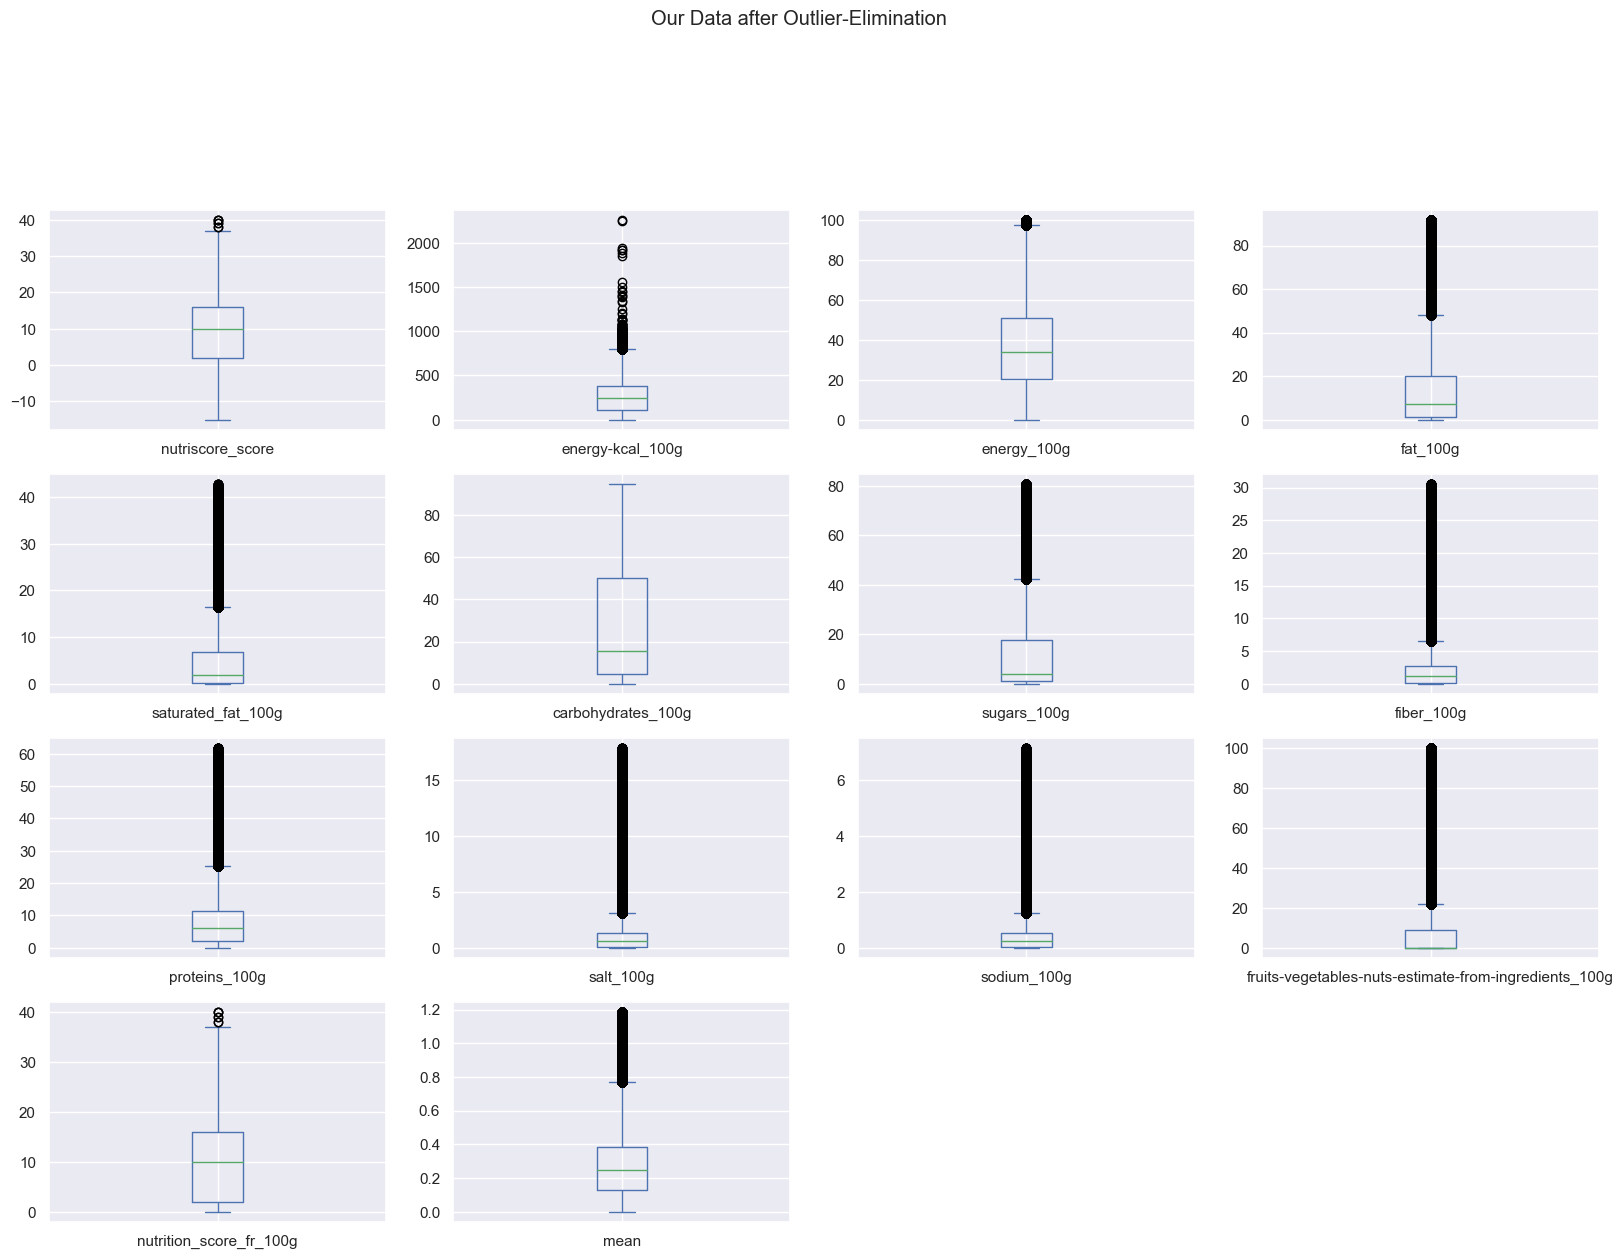

In [78]:
filled.select_dtypes(include=float).plot(kind='box', subplots=True, title='Our Data after Outlier-Elimination KDtree', figsize=(20,20), layout=(6,4))

plt.show()

In [79]:
filled.to_csv ('../data/data_cleaned_and_without_outliners_Open_Foods.csv', index = False, header=True)


###################### Fin Netoyage et Preprocessing #####################